In [1]:
%cd ..

/home/jovyan/3d-AAE


In [2]:
!pwd

/home/jovyan/3d-AAE


In [3]:
import numpy as np
from sklearn.manifold import TSNE
import argparse
import json
import logging
import random
from datetime import datetime
from importlib import import_module
from itertools import chain
from os.path import join, exists
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad
import torch.backends.cudnn as cudnn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.utils.data import DataLoader

from utils.pcutil import plot_3d_point_cloud
from utils.util import find_latest_epoch, prepare_results_dir, cuda_setup, setup_logging

cudnn.benchmark = True
import numpy as np
import seaborn as sns

# Copied from the other code

In [2]:
#%cd ..

/home/jovyan/3d-AAE


In [4]:
import argparse
import json
import logging
import random
from datetime import datetime
from importlib import import_module
from itertools import chain
from os.path import join, exists
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad
import torch.backends.cudnn as cudnn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.utils.data import DataLoader

from utils.pcutil import plot_3d_point_cloud
from utils.util import find_latest_epoch, prepare_results_dir, cuda_setup, setup_logging

cudnn.benchmark = True
import numpy as np

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname in ('Conv1d', 'Linear'):
        torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)


In [6]:
with open('/home/jovyan/3d-AAE/settings/hyperparams.json') as f:
    config = json.load(f)

In [7]:
random.seed(config['seed'])
torch.manual_seed(config['seed'])
torch.cuda.manual_seed_all(config['seed'])

results_dir = prepare_results_dir(config)
starting_epoch = find_latest_epoch(results_dir) + 1

if not exists(join(results_dir, 'config.json')):
    with open(join(results_dir, 'config.json'), mode='w') as f:
        json.dump(config, f)

setup_logging(results_dir)
log = logging.getLogger(__name__)

device = cuda_setup(config['cuda'], config['gpu'])
log.debug(f'Device variable: {device}')
if device.type == 'cuda':
    log.debug(f'Current CUDA device: {torch.cuda.current_device()}')

weights_path = join(results_dir, 'weights')

2021-08-12 15:56:16,125: DEBUG    Device variable: cuda
2021-08-12 15:56:16,127: DEBUG    Current CUDA device: 0


In [8]:
#
# Dataset
#
dataset_name = config['dataset'].lower()
if dataset_name == 'shapenet':
    from datasets.shapenet import ShapeNetDataset
    dataset = ShapeNetDataset(root_dir=config['data_dir'],
                              classes=config['classes'])
elif dataset_name == 'faust':
    from datasets.dfaust import DFaustDataset
    dataset = DFaustDataset(root_dir=config['data_dir'],
                            classes=config['classes'])
else:
    raise ValueError(f'Invalid dataset name. Expected `shapenet` or '
                     f'`faust`. Got: `{dataset_name}`')
log.debug("Selected {} classes. Loaded {} samples.".format(
    'all' if not config['classes'] else ','.join(config['classes']),
    len(dataset)))

points_dataloader = DataLoader(dataset, batch_size=config['batch_size'],
                               shuffle=config['shuffle'],
                               num_workers=config['num_workers'],
                               drop_last=True, pin_memory=True)

2021-08-12 15:56:18,900: DEBUG    Selected all classes. Loaded 48809 samples.


In [9]:
#
# Models
#
arch = import_module(f"models.{config['arch']}")
G = arch.Generator(config).to(device)
E = arch.Encoder(config).to(device)
D = arch.Discriminator(config).to(device)

G.apply(weights_init)
E.apply(weights_init)
D.apply(weights_init)

if config['reconstruction_loss'].lower() == 'chamfer':
    from losses.champfer_loss import ChamferLoss
    reconstruction_loss = ChamferLoss().to(device)
elif config['reconstruction_loss'].lower() == 'earth_mover':
    from losses.earth_mover_distance import EMD
    reconstruction_loss = EMD().to(device)
else:
    raise ValueError(f'Invalid reconstruction loss. Accepted `chamfer` or '
                     f'`earth_mover`, got: {config["reconstruction_loss"]}')

In [10]:
#
# Float Tensors
#
fixed_noise = torch.FloatTensor(config['batch_size'], config['z_size'], 1)
fixed_noise.normal_(mean=config['normal_mu'], std=config['normal_std'])
noise = torch.FloatTensor(config['batch_size'], config['z_size'])

fixed_noise = fixed_noise.to(device)
noise = noise.to(device)

In [16]:
#
# Optimizers
#
EG_optim = getattr(optim, config['optimizer']['EG']['type'])
EG_optim = EG_optim(chain(E.parameters(), G.parameters()),
                    **config['optimizer']['EG']['hyperparams'])

D_optim = getattr(optim, config['optimizer']['D']['type'])
D_optim = D_optim(D.parameters(),
                  **config['optimizer']['D']['hyperparams'])

In [11]:
starting_epoch=1719
print(join(weights_path, f'{starting_epoch-1:05}_G.pth'))
E.load_state_dict(torch.load('/home/jovyan/3d-AAE/test-results/aae/experiment/weights/chair01720_E.pth'))
G.load_state_dict(torch.load('/home/jovyan/3d-AAE/test-results/aae/experiment/weights/chair01720_G.pth'))

/home/jovyan/3d-AAE/test-results/aae/experiment/weights/01718_G.pth


<All keys matched successfully>

In [18]:
G.eval()
E.eval()
D.eval()

codes_car=[]
codes_all=[]
labels_all=[]

# with torch.no_grad():
#     for i, point_data in enumerate(points_dataloader, 1):
#         log.debug('-' * 20)
#         X, labels = point_data
#         #print(_)
#         X = X.to(device)
#         if X.size(-1) == 3:
#             X.transpose_(X.dim() - 2, X.dim() - 1)
    
#         codes, _, _ = E(X)
        
        #saving only latent cars
#         for i in range(50):
#             if labels[i]==16:
#                 codes_car.append(list(codes[i].cpu().numpy()))
                
    
        #saving all latent objects 
#         for i in range(50):
#             if labels[i]==16 or labels[i]==21:
#                 codes_all.append(list(codes[i].cpu().numpy()))
#                 labels_all.append(labels[i])

                

In [15]:
a= np.asarray(codes_all)
np.save('all_latent.npy', a)

In [19]:
a= np.asarray(labels_all)
np.save('all_labels.npy', a)

# Experiments in the latent space

In [19]:
all_codes= np.load('all_latent.npy')
all_labels= np.load('all_labels.npy')

In [20]:
def plot_3d_point_cloud(x, y, z, show=True, show_axis=True, in_u_sphere=False,
                        marker='.', s=8, alpha=.8, figsize=(5, 5), elev=10,
                        azim=240, axis=None, title=None, *args, **kwargs):
    #plt.switch_backend('agg')
    
    if axis is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')
    else:
        ax = axis
        fig = axis

    if title is not None:
        plt.title(title)

    sc = ax.scatter(x, y, z, marker=marker, s=s, alpha=alpha, *args, **kwargs)
    ax.view_init(elev=elev, azim=azim)

    if in_u_sphere:
        ax.set_xlim3d(-0.5, 0.5)
        ax.set_ylim3d(-0.5, 0.5)
        ax.set_zlim3d(-0.5, 0.5)
    else:
        # Multiply with 0.7 to squeeze free-space.
        miv = 0.7 * np.min([np.min(x), np.min(y), np.min(z)])
        mav = 0.7 * np.max([np.max(x), np.max(y), np.max(z)])
        ax.set_xlim(miv, mav)
        ax.set_ylim(miv, mav)
        ax.set_zlim(miv, mav)
        plt.tight_layout()

    if not show_axis:
        plt.axis('off')

    if 'c' in kwargs:
        plt.colorbar(sc)

    if show:
        plt.show()

    return fig

In [21]:
def reconstruct_from_code(code):
    av=[]
    for i in range(50):
        av.append(code)
    av=np.reshape(av, (2048, 50)).T
    codes=torch.from_numpy(av).to("cuda")
    
    with torch.no_grad():
        X_rec = G(codes).data.cpu().numpy()
    #print(X_rec[30]==X_rec[10])
    return X_rec[0]

In [18]:
all_codes.shape

(13600, 2048)

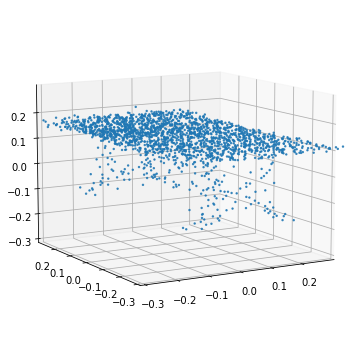

In [20]:
A=reconstruct_from_code(all_codes[100])
plot= plot_3d_point_cloud(A[0], A[1], A[2])

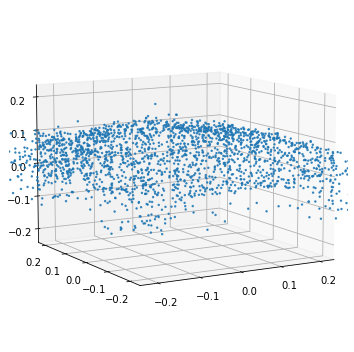

In [21]:
shuffle = np.copy(all_codes[100])
np.random.shuffle(shuffle)
B=reconstruct_from_code(shuffle)
plot= plot_3d_point_cloud(B[0], B[1], B[2])

PCA and T-SNE plots for the latent space

In [27]:
car_codes= np.load('car_latent.npy')

In [28]:
import numpy as np
from sklearn.manifold import TSNE


In [29]:
car_codes.shape

(6370, 2048)

In [30]:
X_embedded = TSNE(n_components=2).fit_transform(car_codes.T)

KeyboardInterrupt: 

In [33]:
X_embedded= np.load('car_feature_tsne.npy')

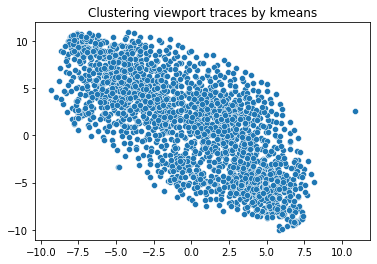

In [26]:
import seaborn as sns
palette = sns.color_palette("bright", 24)
plt.figure()
plt.title('Clustering viewport traces by kmeans')
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], legend='full', palette=palette)
plt.show()

Clustering in the latent space

In [27]:
from sklearn.cluster import KMeans
n=24
kmeans = KMeans(n_clusters=n, random_state=0).fit(car_codes.T)
a=kmeans.labels_

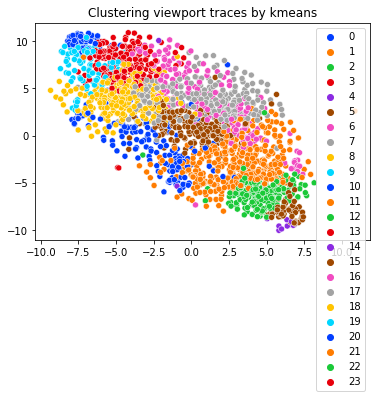

In [28]:
palette = sns.color_palette("bright", 24)
plt.figure()
plt.title('Clustering viewport traces by kmeans')
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue= a, legend='full', palette=palette)
plt.show()

In [34]:
from sklearn.cluster import KMeans
n=5
kmeans = KMeans(n_clusters=n, random_state=0).fit(car_codes.T)
a=kmeans.labels_

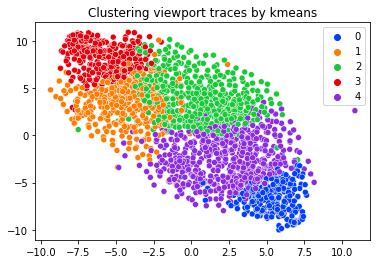

In [35]:
palette = sns.color_palette("bright", 5)
plt.figure()
plt.title('Clustering viewport traces by kmeans')
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue= a, legend='full', palette=palette)
plt.show()

feature removal and reconstruction

In [37]:
def plot_3d_point_cloud_dual(x1,y1,z1,x2,y2,z2, marker='.', s=8, alpha=.8, figsize=(10, 10), elev=10,
                        azim=240, axis=None, title=None):
    #plt.switch_backend('agg')
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(121, projection='3d')

    sc = ax.scatter(x1, y1, z1, marker=marker, s=s, alpha=alpha)
    ax.view_init(elev=elev, azim=azim)

    miv = 0.7 * np.min([np.min(x1), np.min(y1), np.min(z1)])
    mav = 0.7 * np.max([np.max(x1), np.max(y1), np.max(z1)])
    ax.set_xlim(miv, mav)
    ax.set_ylim(miv, mav)
    ax.set_zlim(miv, mav)
    
    ax2 = fig.add_subplot(122, projection='3d')

    sc = ax2.scatter(x2, y2, z2, marker=marker, s=s, alpha=alpha)
    ax2.view_init(elev=elev, azim=azim)

    miv = 0.7 * np.min([np.min(x2), np.min(y2), np.min(z2)])
    mav = 0.7 * np.max([np.max(x2), np.max(y2), np.max(z2)])
    ax2.set_xlim(miv, mav)
    ax2.set_ylim(miv, mav)
    ax2.set_zlim(miv, mav)
    
    
    plt.tight_layout()

    #plt.axis('off')
    plt.show(fig)

    #return fig

In [38]:
def reconstruct_from_code(code):
    av=[]
    for i in range(50):
        av.append(code)
    av=np.reshape(av, (2048, 50)).T
    codes=torch.from_numpy(av).to("cuda")
    
    with torch.no_grad():
        X_rec = G(codes).data.cpu().numpy()
    #print(X_rec[30]==X_rec[10])
    return X_rec[0]

In [37]:
a=kmeans.labels_
a

array([ 2,  5, 10, ...,  7,  7,  7], dtype=int32)

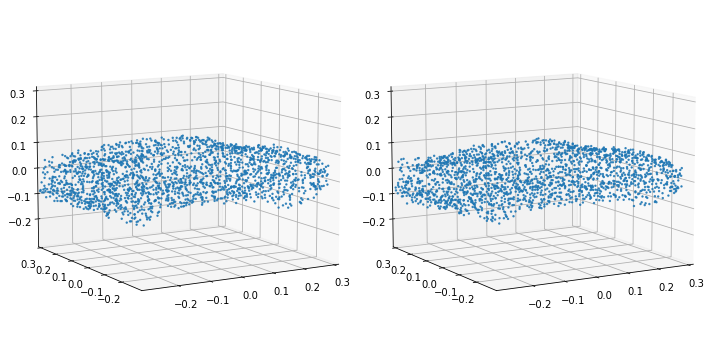

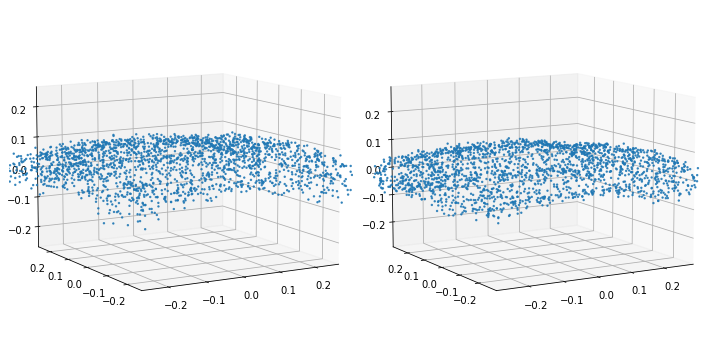

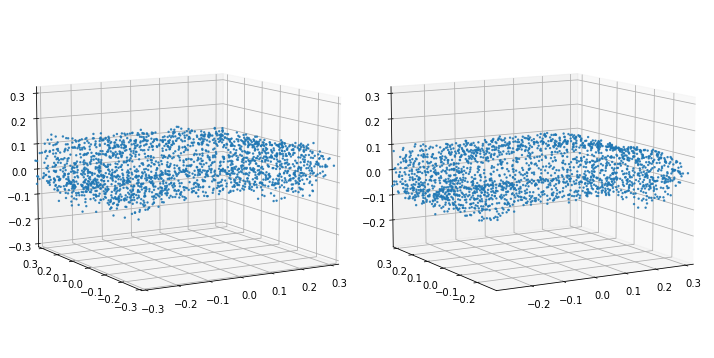

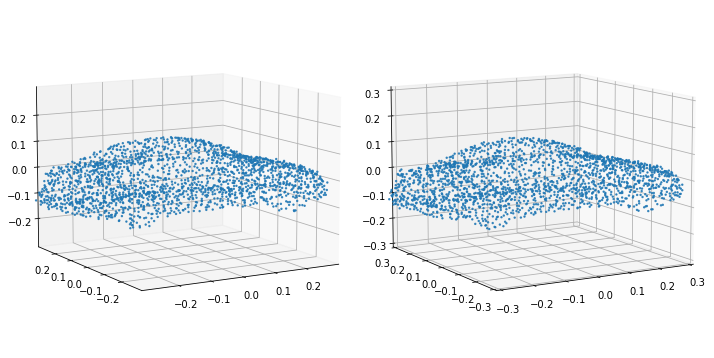

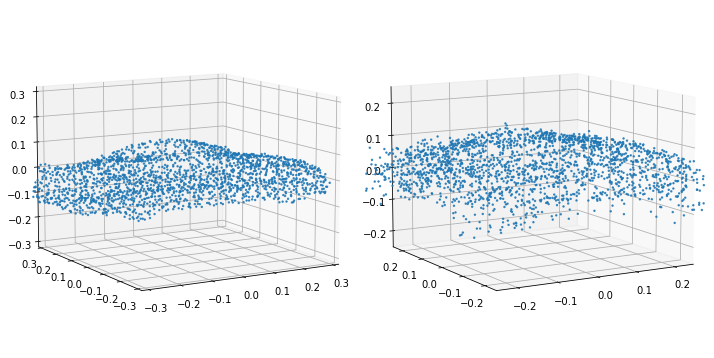

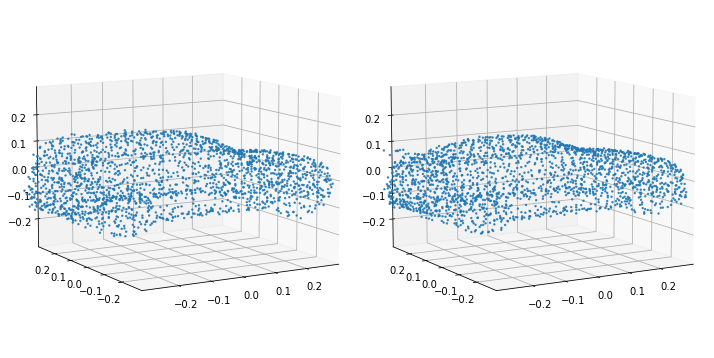

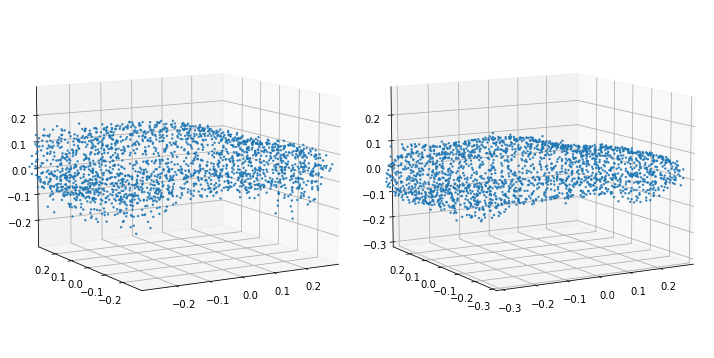

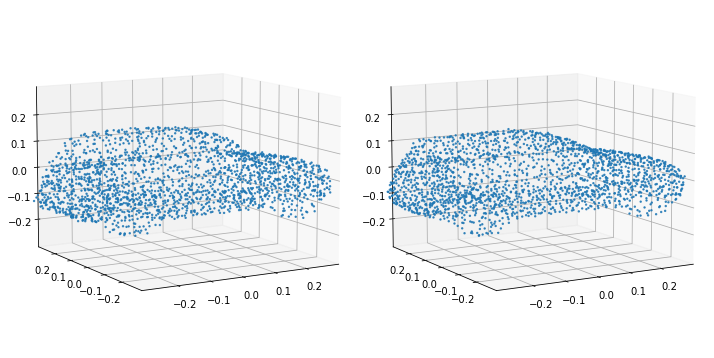

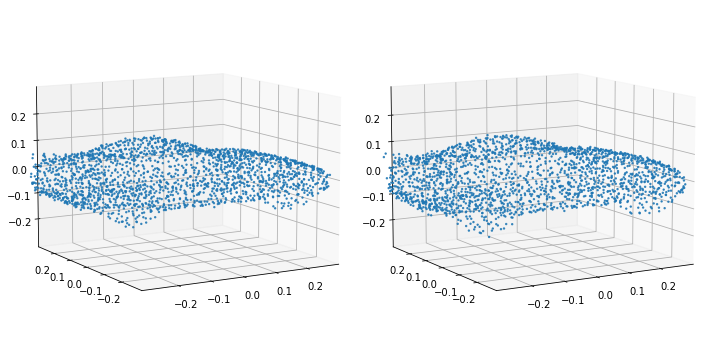

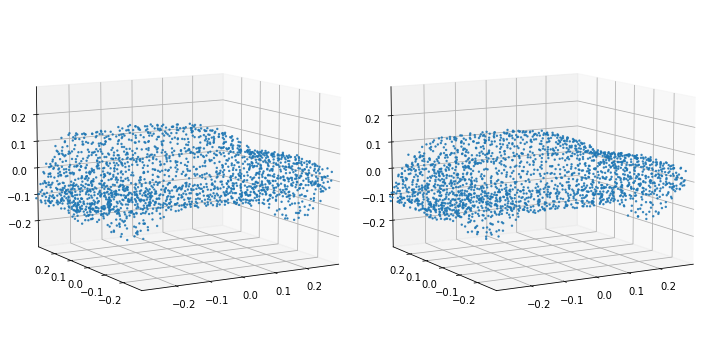

In [75]:
for j in range(10):
    obj=10*j
    feature_rem=0
    code1= np.copy(car_codes[obj])
    code2= np.copy(car_codes[obj])
    for i in range(2048):
        if a[i]==feature_rem:
            code2[i]=0
    A= reconstruct_from_code(code1)
    B= reconstruct_from_code(code2)
    plot_3d_point_cloud_dual(A[0],A[1],A[2],B[0],B[1],B[2])

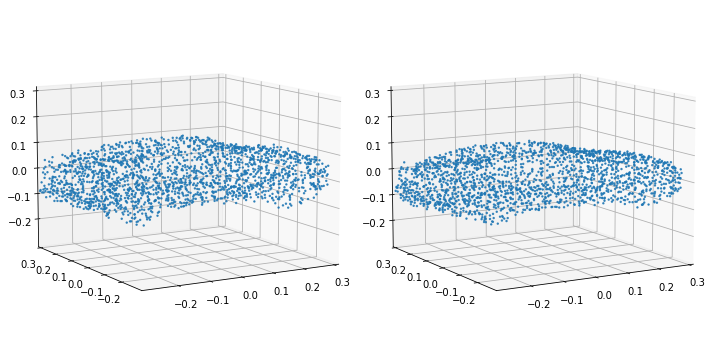

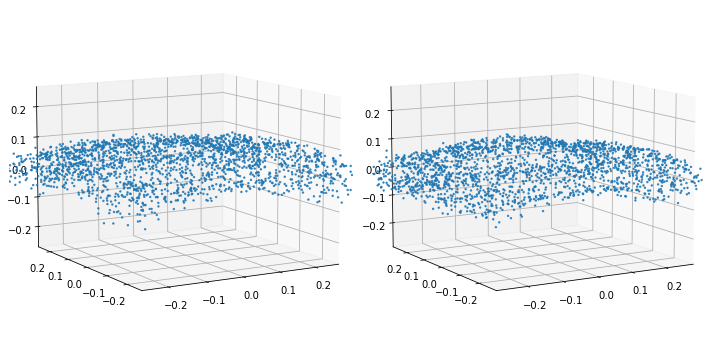

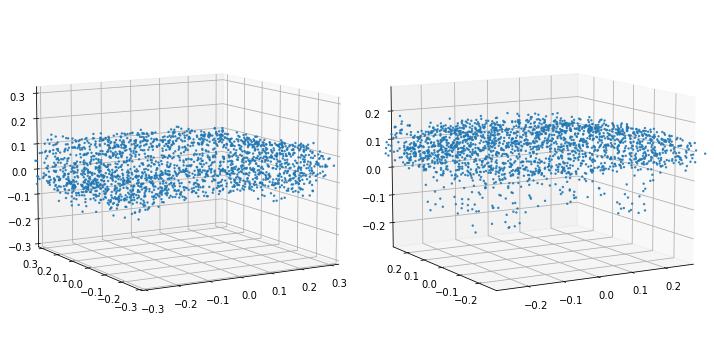

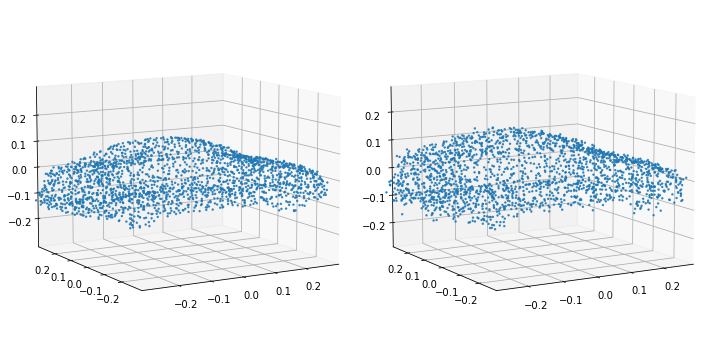

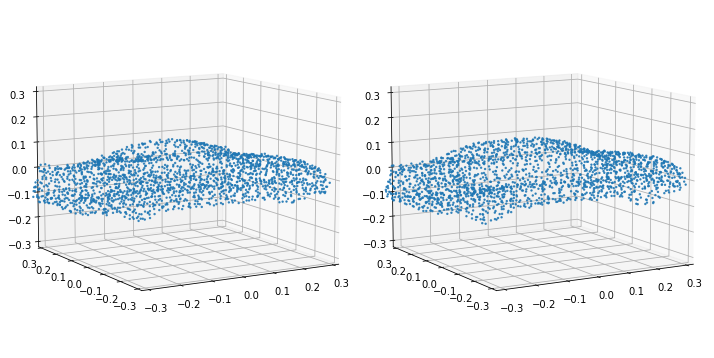

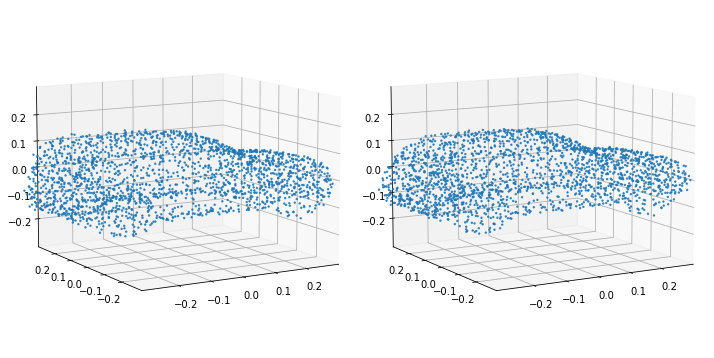

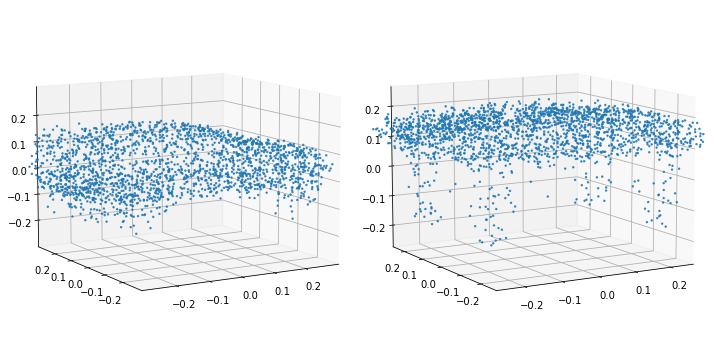

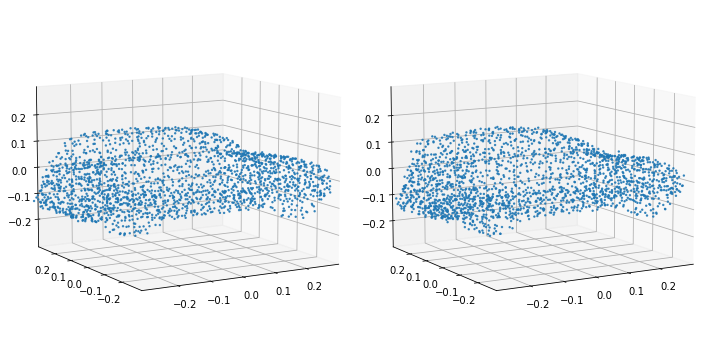

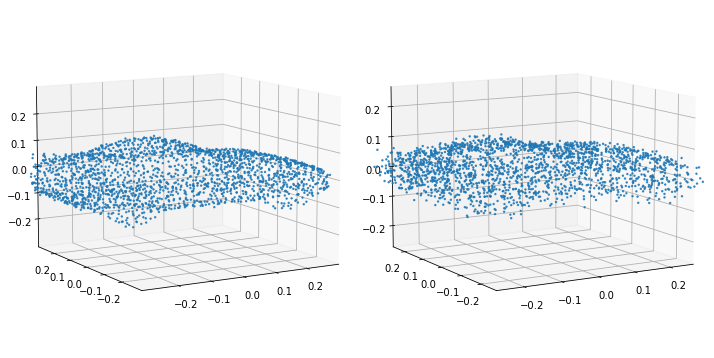

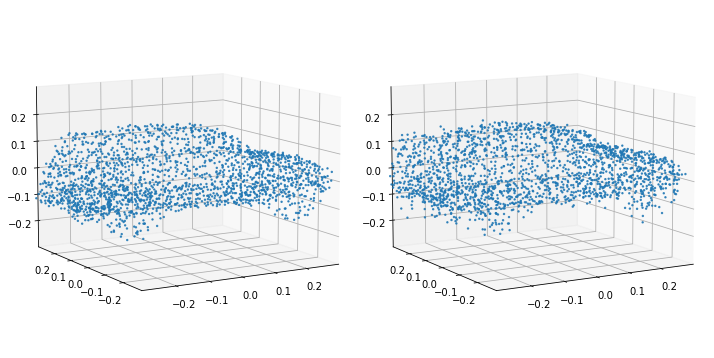

In [39]:
for j in range(10):
    obj=10*j
    feature_rem=4
    code1= np.copy(car_codes[obj])
    code2= np.copy(car_codes[obj])
    for i in range(2048):
        if a[i]==feature_rem:
            code2[i]=0
    A= reconstruct_from_code(code1)
    B= reconstruct_from_code(code2)
    plot_3d_point_cloud_dual(A[0],A[1],A[2],B[0],B[1],B[2])

In [40]:
chair_train= np.load('/home/daia/GPointNet-main/data/chair_train.npy')

In [41]:
chair_test= np.load('/home/daia/GPointNet-main/data/chair_test.npy')

In [43]:
chair_test.shape

(100, 2048, 3)

In [47]:
import gdown
url = 'https://drive.google.com/uc?id=1VBlqbUnMlnwvq3NCwuUiElx__3Z23ABg'
output = '/home/jovyan/3d-AAE/test-results/aae/experiment/weights/chair01720_G.pth'
gdown.download(url, output, quiet=False)

2021-08-12 15:55:33,029: DEBUG    Starting new HTTPS connection (1): drive.google.com:443
2021-08-12 15:55:33,508: DEBUG    https://drive.google.com:443 "GET /uc?id=1VBlqbUnMlnwvq3NCwuUiElx__3Z23ABg HTTP/1.1" 200 None
2021-08-12 15:55:33,574: DEBUG    Starting new HTTPS connection (1): docs.google.com:443
2021-08-12 15:55:34,045: DEBUG    https://docs.google.com:443 "GET /uc?export=download&confirm=qp5V&id=1VBlqbUnMlnwvq3NCwuUiElx__3Z23ABg HTTP/1.1" 200 None
2021-08-12 15:55:34,481: DEBUG    https://docs.google.com:443 "GET /uc?export=download&confirm=GHxM&id=1VBlqbUnMlnwvq3NCwuUiElx__3Z23ABg HTTP/1.1" 302 None
2021-08-12 15:55:34,492: DEBUG    Starting new HTTPS connection (1): doc-0s-0k-docs.googleusercontent.com:443
2021-08-12 15:55:35,992: DEBUG    https://doc-0s-0k-docs.googleusercontent.com:443 "GET /docs/securesc/te502j4mngdnibif106hto8kn4q87d7s/ogeuet6lb60kijpdso6k2re04fgh22gb/1628783700000/17045307817471925288/16759326357461533362Z/1VBlqbUnMlnwvq3NCwuUiElx__3Z23ABg?e=download 

'/home/jovyan/3d-AAE/test-results/aae/experiment/weights/chair01720_G.pth'

In [ ]:
https://drive.google.com/file/d/1wpCuiVyNWcmfmSW3YgPbJp1AM-RWht1g/view?usp=sharing
    https://drive.google.com/file/d/1VBlqbUnMlnwvq3NCwuUiElx__3Z23ABg/view?usp=sharing